In [28]:
import pandas as pd
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense , Dropout
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers, models, regularizers, optimizers

import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

In [2]:
try:
    # Read the data from CSV file
    df = pd.read_csv('enhanced_diabetes_dataset.csv')
    print("Successfully loaded data from enhanced_diabetes_dataset.csv")

except FileNotFoundError:
    print("CSV file not found. Creating a sample dataset and saving it...")

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset information:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

Successfully loaded data from enhanced_diabetes_dataset.csv

First 5 rows of the dataset:
   Age  Gender  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
0   52       1            1      124           95.0           20.0        0   
1   43       1            2      144           86.0           23.0        3   
2   55       1            4      141          113.0           18.0      297   
3   68       1            3      125          110.0           32.0      210   
4   41       0            0      177           92.0           14.0      189   

    BMI  DiabetesPedigreeFunction  HbA1c  FastingBS  Triglycerides   HDL  \
0  36.0                     0.078    4.7         87          142.0  37.0   
1  32.9                     0.118    6.3        135          162.0  89.0   
2  43.4                     0.139    5.4        113          180.0  45.0   
3  22.7                     0.197    5.2         93          262.0  56.0   
4  38.1                     0.078   10.5        126    

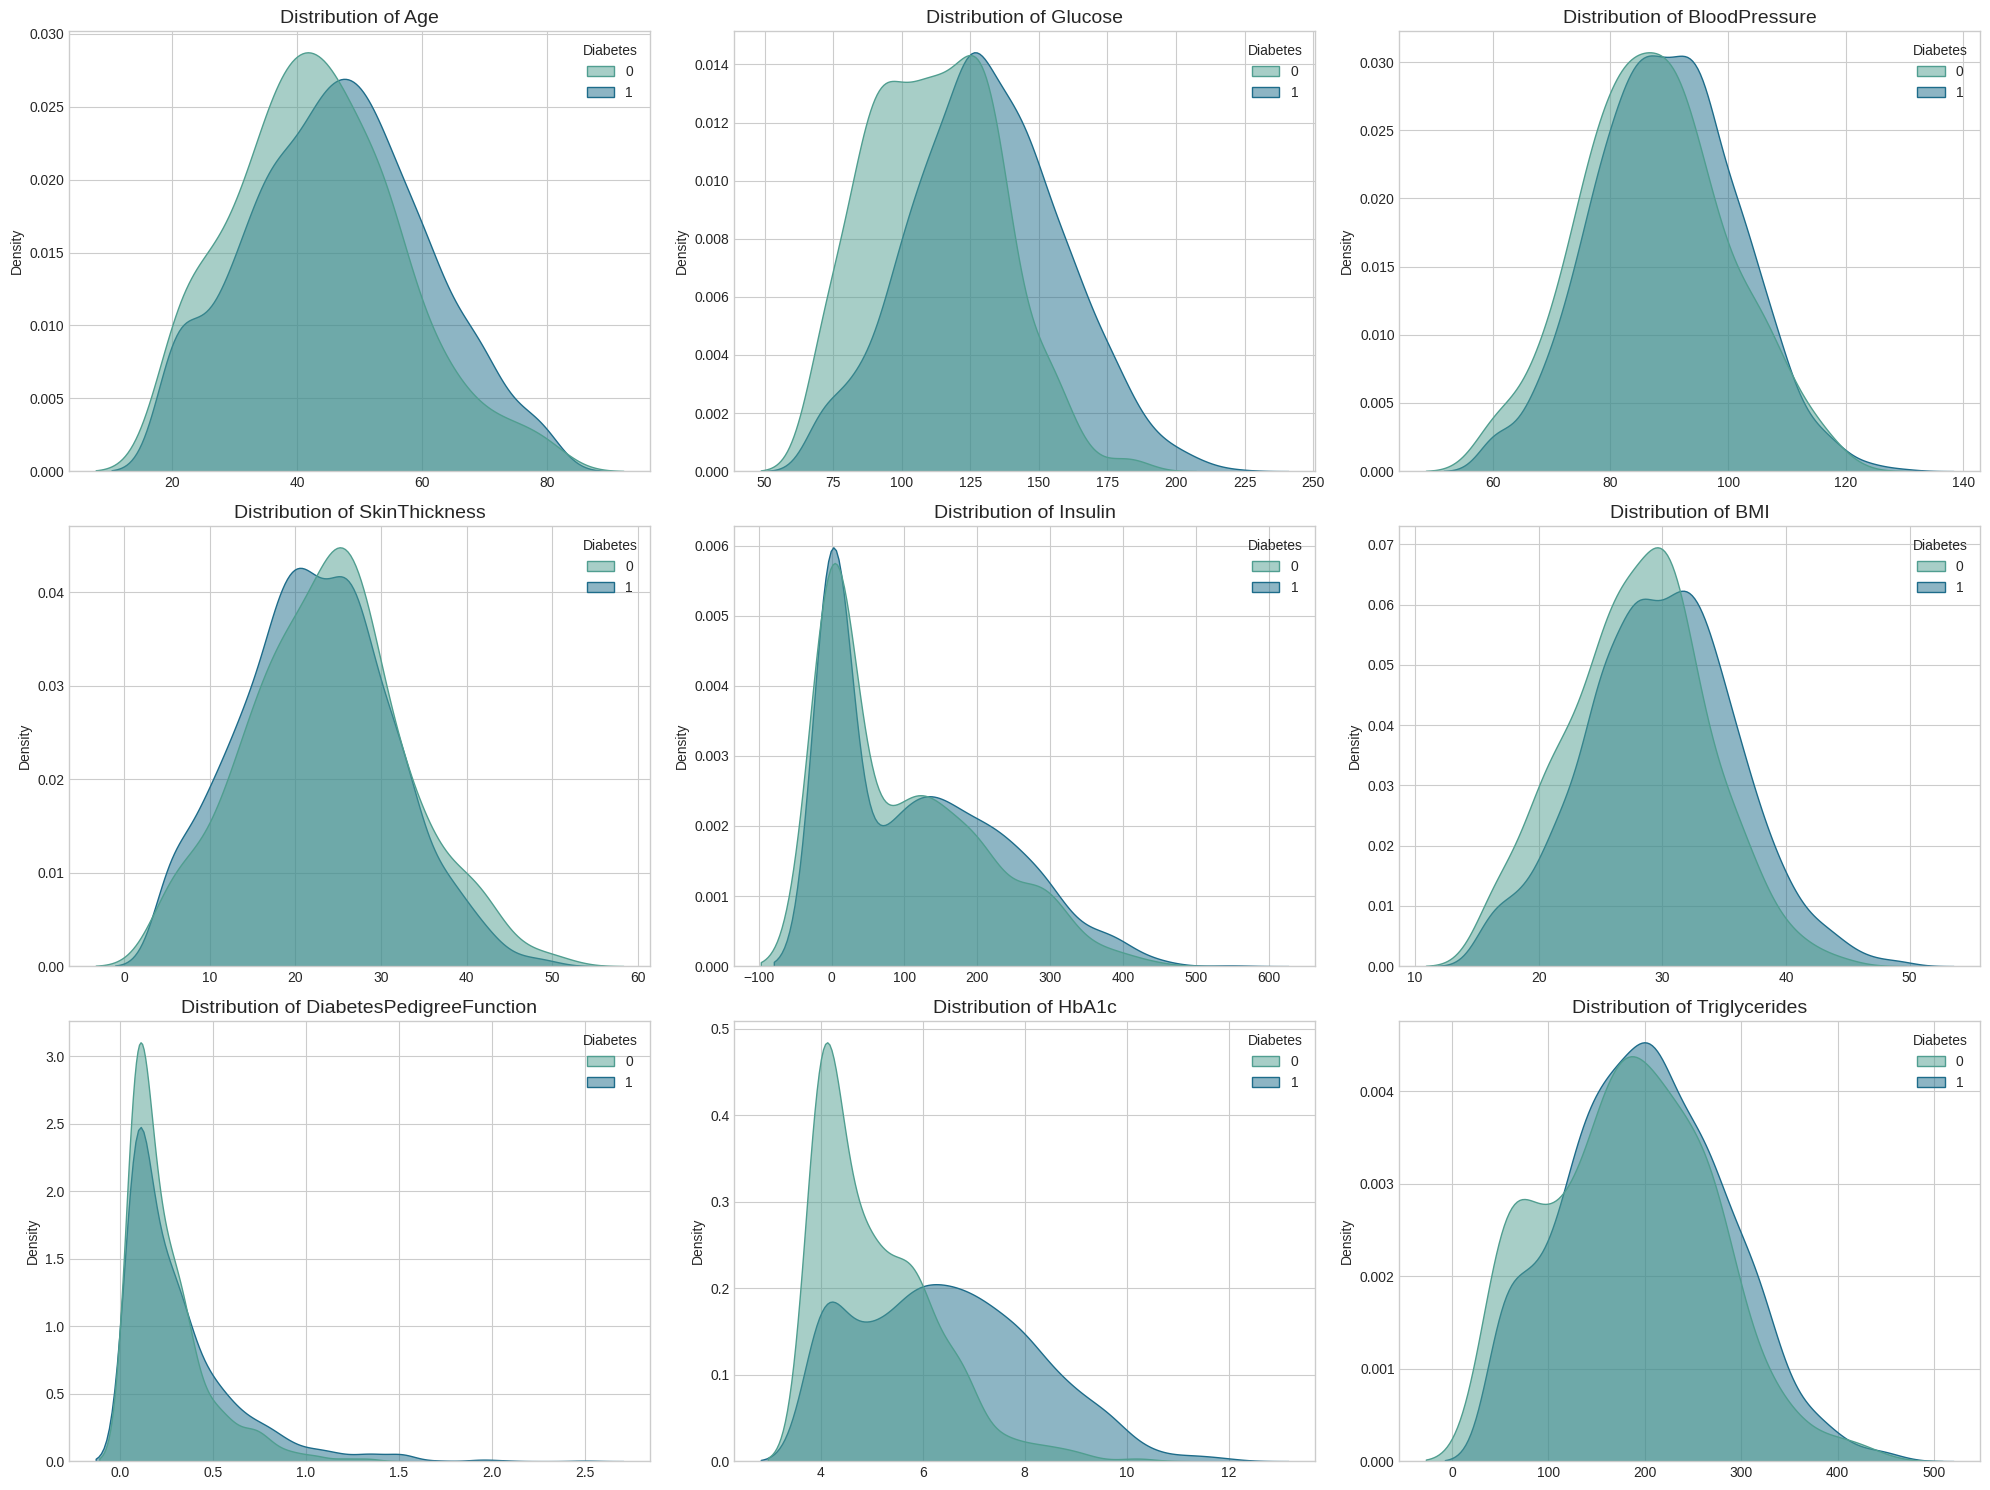

In [3]:
features = ['Age', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
            'BMI', 'DiabetesPedigreeFunction', 'HbA1c', 'Triglycerides']

cols = 3
rows = math.ceil(len(features) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten() # Flatten so we can iterate with a single index

for i, col in enumerate(features):
    # Create a KDE plot for each feature, split by 'Diabetes'
    sns.kdeplot(
        data=df,
        x=col,
        hue='Diabetes',
        fill=True,
        ax=axes[i],
        palette='crest',
        common_norm=False,
        alpha=0.5
    )
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('') # Clear x-label to keep it clean

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

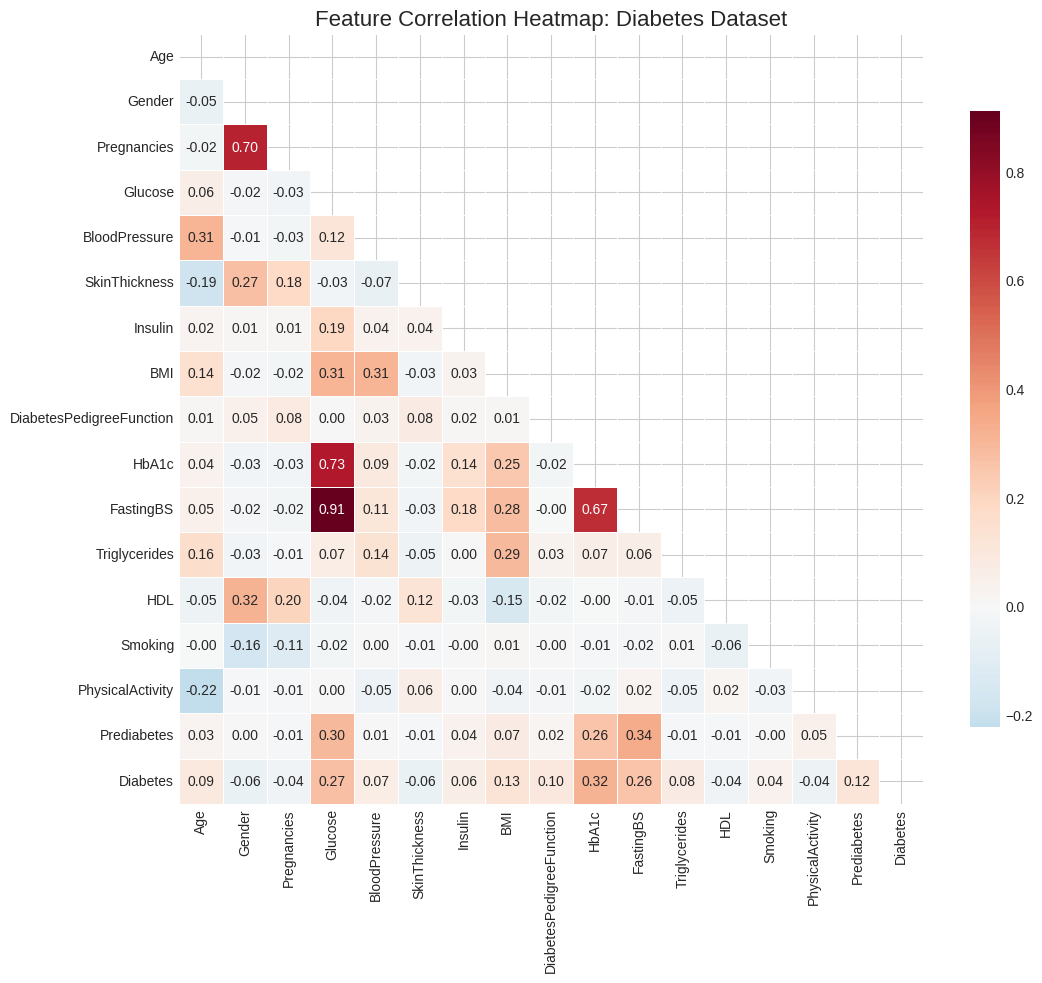

In [4]:
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='RdBu_r',
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Feature Correlation Heatmap: Diabetes Dataset', fontsize=16)
plt.show()

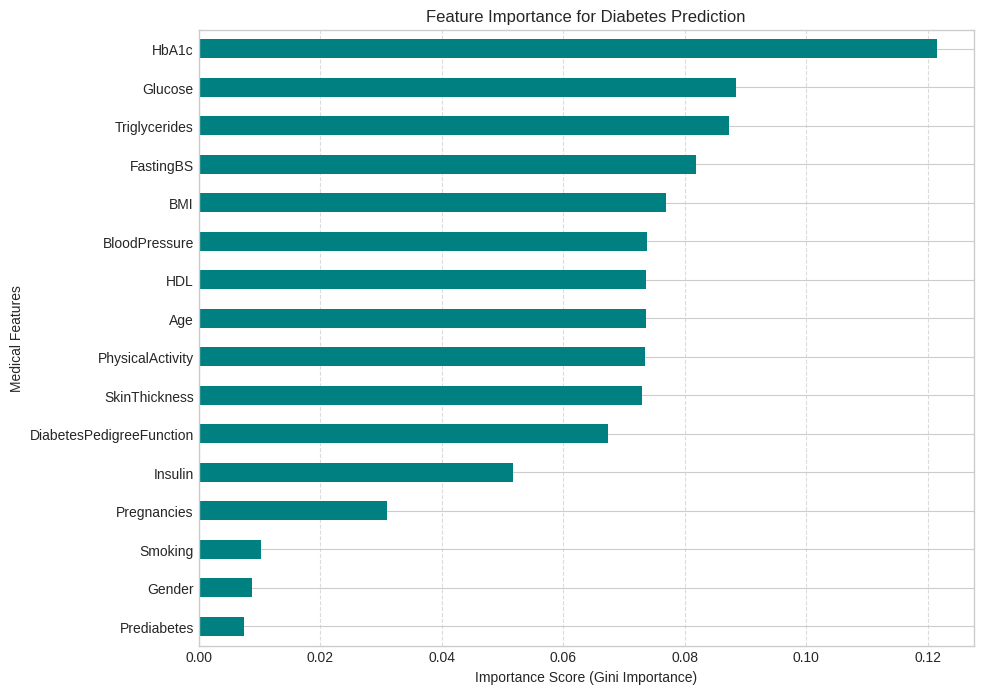

In [5]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

# Train a quick Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extract and organize the importance scores
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True) # Sort for the plot

plt.figure(figsize=(10, 8))
importances.plot(kind='barh', color='teal')
plt.title('Feature Importance for Diabetes Prediction')
plt.xlabel('Importance Score (Gini Importance)')
plt.ylabel('Medical Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

We observe that the 3 most important features are HbA1c, Glucose and Triglycerides.

In [6]:
# Check for missing values
print("Missing Values per Column:")
print(df.isnull().sum())
print(f"\nTotal Missing Values: {df.isnull().sum().sum()}")

Missing Values per Column:
Age                           0
Gender                        0
Pregnancies                   0
Glucose                       0
BloodPressure                98
SkinThickness                86
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
HbA1c                         0
FastingBS                     0
Triglycerides                91
HDL                          96
Smoking                       0
PhysicalActivity            101
Prediabetes                   0
Diabetes                      0
dtype: int64

Total Missing Values: 472


In [7]:
missing_cols = ['BloodPressure', 'SkinThickness', 'Triglycerides', 'HDL', 'PhysicalActivity']

# Strategy: Fill with Median
for col in missing_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Verification
print(df[missing_cols].isnull().sum())

BloodPressure       0
SkinThickness       0
Triglycerides       0
HDL                 0
PhysicalActivity    0
dtype: int64


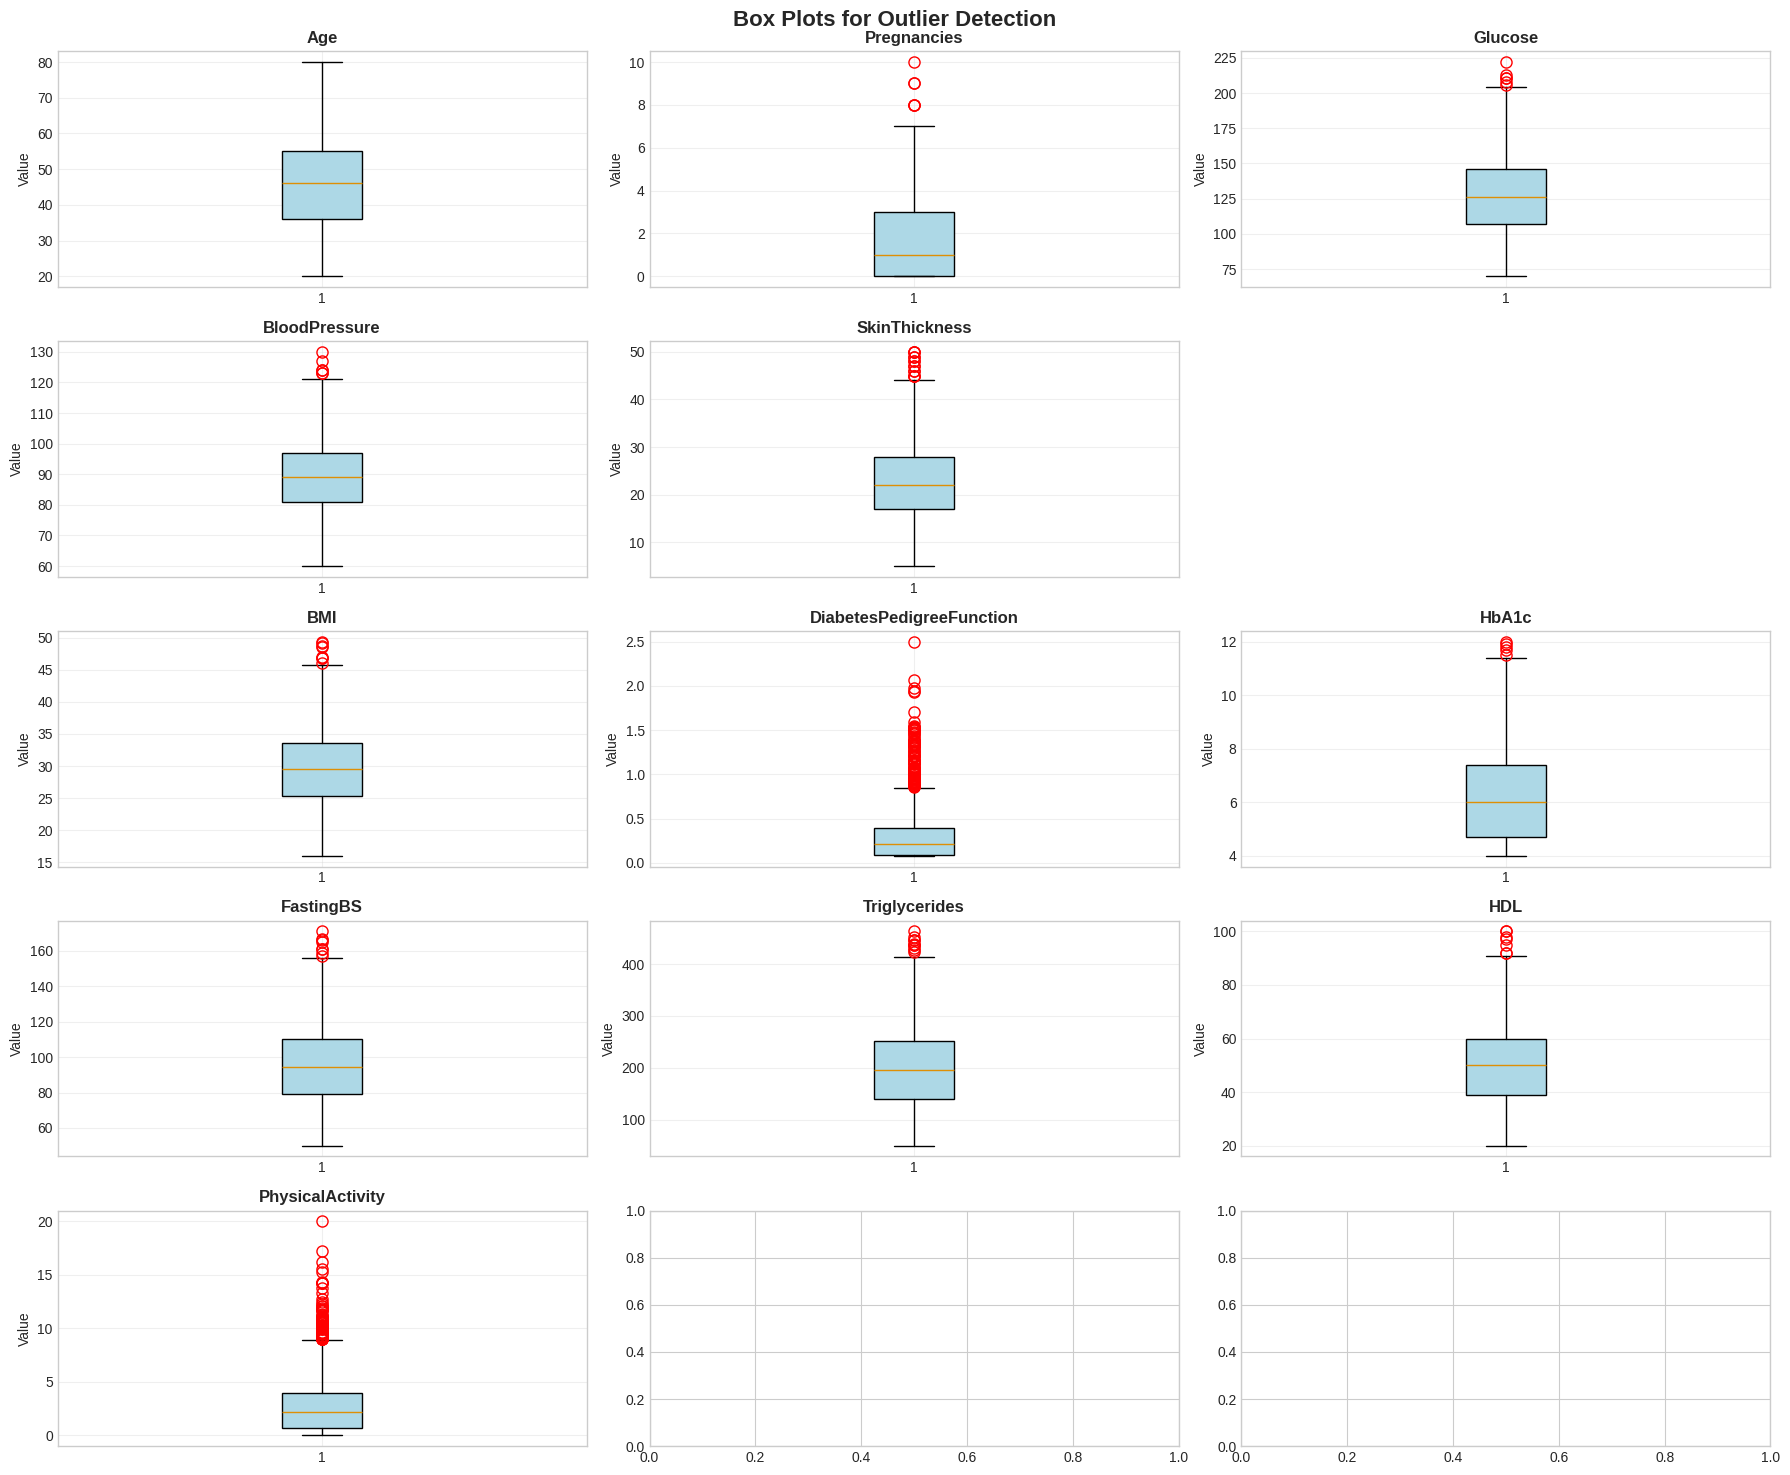

In [8]:
# List of features to visualise outliers, removed categorical variables
numeric_features = [
    'Age', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'HbA1c',
    'FastingBS', 'Triglycerides', 'HDL', 'PhysicalActivity'
]

cols = 3
rows = math.ceil(len(numeric_features) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
axes = axes.flatten()

# Plot box plots to view outliers
for i, col in enumerate(numeric_features):
    # Create box plot
    bp = axes[i].boxplot(df[col], patch_artist=True)

    # Color the box
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_edgecolor('black')

    # Highlight outliers in red
    bp['fliers'][0].set_markeredgecolor('red')
    bp['fliers'][0].set_markersize(8)

    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Box Plots for Outlier Detection',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

We observe that DiabetesPedigreeFunction and Physical Activity contains a significant amount of outliers. The approach I decided to resolve such outliers is to implement a Winsorization (Clipping) at the 1st and 99th percentiles.

This will preserve the data's sample size and also prevent extreme values for the 2 mentioned features.

In [9]:
def cap_outliers(df, columns):
    for col in columns:
        lower_limit = df[col].quantile(0.01)
        upper_limit = df[col].quantile(0.99)
        # Values below 1st percentile become the 1st percentile value
        # Values above 99th percentile become the 99th percentile value
        df[col] = df[col].clip(lower_limit, upper_limit)
    return df

outlier_features = ['DiabetesPedigreeFunction', 'PhysicalActivity']
df = cap_outliers(df, outlier_features)

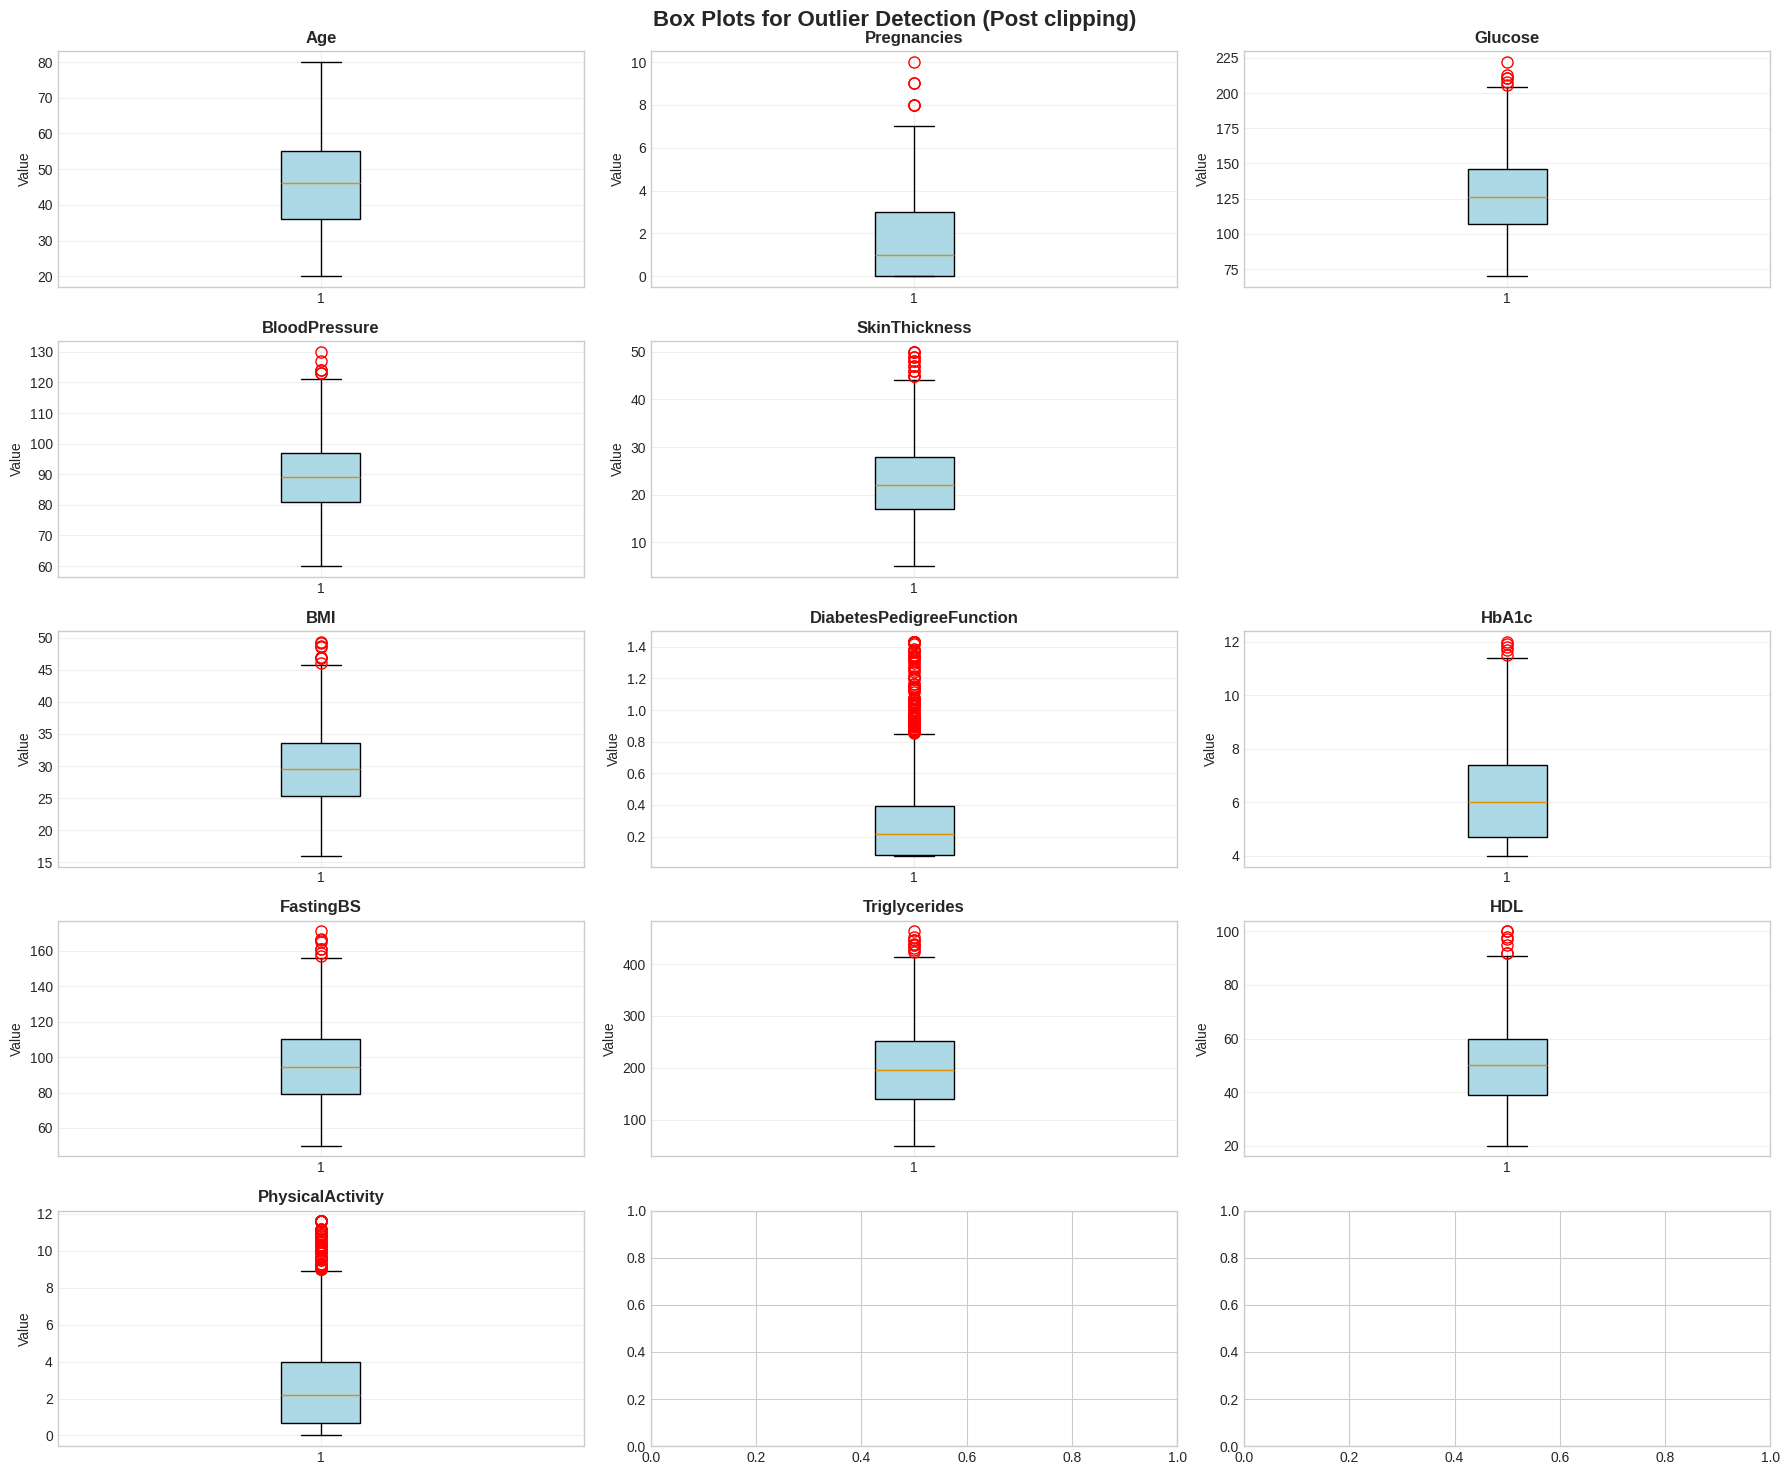

In [10]:
# Re plotting of the box plots to verify that the clipping strategy
cols = 3
rows = math.ceil(len(numeric_features) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
axes = axes.flatten()

# Plot box plots to view outliers
for i, col in enumerate(numeric_features):
    # Create box plot
    bp = axes[i].boxplot(df[col], patch_artist=True)

    # Color the box
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_edgecolor('black')

    # Highlight outliers in red
    bp['fliers'][0].set_markeredgecolor('red')
    bp['fliers'][0].set_markersize(8)

    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Box Plots for Outlier Detection (Post clipping)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

We now observe and verified that the maximum values for DiabetesPedigreeFunction and PhysicalActivity are now reduced,  (2.5 to 1.4) and (25 to 12) respectively.

In [11]:
X = df.drop('Diabetes', axis=1)

# We take the 'Diabetes' column for y
y = df['Diabetes']

# Visualise the first few rows for X and y
print("\nDataset X information: \n")
print(X.head())

print("\nDataset y information: \n")
print(y.head())


Dataset X information: 

   Age  Gender  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
0   52       1            1      124           95.0           20.0        0   
1   43       1            2      144           86.0           23.0        3   
2   55       1            4      141          113.0           18.0      297   
3   68       1            3      125          110.0           32.0      210   
4   41       0            0      177           92.0           14.0      189   

    BMI  DiabetesPedigreeFunction  HbA1c  FastingBS  Triglycerides   HDL  \
0  36.0                     0.078    4.7         87          142.0  37.0   
1  32.9                     0.118    6.3        135          162.0  89.0   
2  43.4                     0.139    5.4        113          180.0  45.0   
3  22.7                     0.197    5.2         93          262.0  56.0   
4  38.1                     0.078   10.5        126          332.0  66.0   

   Smoking  PhysicalActivity  Prediabetes 

In [12]:
from sklearn.model_selection import train_test_split

# Split the data first to prevent data leakage in standardization
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit and transform ONLY the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform Val and Test using Training's mean/std
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [56]:
from imblearn.combine import SMOTETomek
from collections import Counter

sm = SMOTETomek(sampling_strategy=0.6, random_state=42)

# Apply SMOTE ONLY to the Training Data
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# Verify the balance
print(f"Original dataset shape: {Counter(y_train)}")
print(f"Resampled dataset shape: {Counter(y_train_res)}")

Original dataset shape: Counter({1: 1126, 0: 274})
Resampled dataset shape: Counter({1: 1120, 0: 669})


In [57]:
def build_model(learning_rate=0.001, dropout_rate=0.2, filters=32, kernel_size=2):
    model = models.Sequential([

        # Layer 1: Convolutional Base
        layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            input_shape=(X_train_res.shape[1], 1),
            kernel_regularizer=regularizers.l2(0.01), # L2 regularization
        ),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),

        # Layer 2: Deeper Feature Extraction
        layers.Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(dropout_rate), # Prevents overfitting

        # Layer 3: Flattening to Transition to Classification
        layers.Flatten(),

        # Layer 4: Fully Connected (Dense) Layer
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model with the dynamic learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

# Implement an early stopping measure
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Implement checkpointing
checkpoint = ModelCheckpoint(
    'best_diabetes_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [60]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

In [61]:
model = build_model(learning_rate=0.001, dropout_rate=0.5, filters=32, kernel_size=2)

history = model.fit(
    X_train_res, y_train_res,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6341 - loss: 1.0785
Epoch 1: val_loss improved from inf to 0.99268, saving model to best_diabetes_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6350 - loss: 1.0770 - val_accuracy: 0.7433 - val_loss: 0.9927 - learning_rate: 0.0010
Epoch 2/200
41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7476 - loss: 0.8779
Epoch 2: val_loss improved from 0.99268 to 0.90601, saving model to best_diabetes_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7430 - loss: 0.8781 - val_accuracy: 0.7967 - val_loss: 0.9060 - learning_rate: 0.0010
Epoch 3/200
41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7160 - loss: 0.8267
Epoch 3: val_loss improved from 0.90601 to 0.86470, saving model to best_diabetes_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7177 - loss: 0.8215 - val_accuracy: 0.6800 - val_loss: 0.8647 - learning_rate: 0.0010
Epoch 4/200
40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accurac

In [62]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train_res, y_train_res)
print('Accuracy: %.2f' % (accuracy*100))

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8350 - loss: 0.4309
Accuracy: 82.73


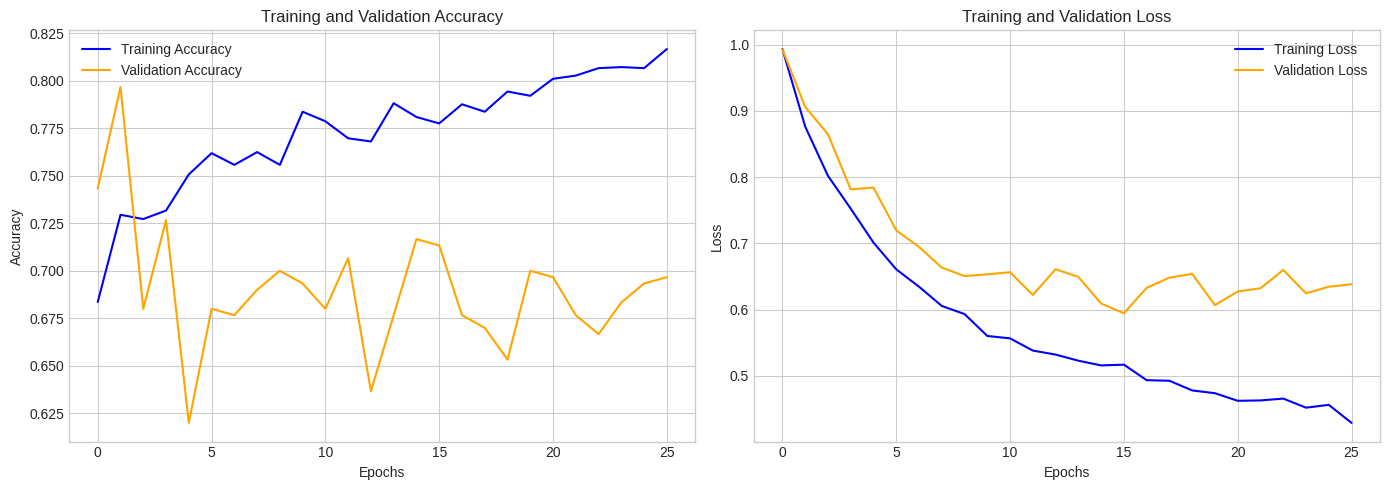

In [63]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The model reached optimal convergence at epoch 24, triggered by the early stopping callback. This prevented the model from entering the overfitting phase, where training accuracy continues to rise while validation performance drops.

In [64]:
# Parameter tuning

learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]
dropout_rate = 0.2
filter_num = [32, 64]
kernel_size = 3

results = []

for lr in learning_rates:
    for batch in batch_sizes:
      for filter in filter_num:
        print(f"Testing: LR={lr}, Batch={batch}")

        grid_model = build_model(learning_rate=lr, dropout_rate=dropout_rate,
                            filters=filter, kernel_size=kernel_size)

        history = grid_model.fit(
            X_train_res, y_train_res,
            epochs=50, # Shorter epochs for tuning
            batch_size=batch,
            validation_data=(X_val_scaled, y_val),
            callbacks=[early_stop, checkpoint, lr_scheduler],
            verbose=0
        )

        max_val_acc = max(history.history['val_accuracy'])
        results.append({'LR': lr, 'Batch': batch, 'Val_Acc': max_val_acc})

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Val_Acc', ascending=False))

Testing: LR=0.01, Batch=16

Epoch 1: val_loss did not improve from 0.59440

Epoch 2: val_loss did not improve from 0.59440

Epoch 3: val_loss improved from 0.59440 to 0.59052, saving model to best_diabetes_model.keras

Epoch 4: val_loss improved from 0.59052 to 0.55243, saving model to best_diabetes_model.keras

Epoch 5: val_loss did not improve from 0.55243

Epoch 6: val_loss did not improve from 0.55243

Epoch 7: val_loss did not improve from 0.55243

Epoch 8: val_loss did not improve from 0.55243

Epoch 9: val_loss improved from 0.55243 to 0.54557, saving model to best_diabetes_model.keras

Epoch 10: val_loss did not improve from 0.54557

Epoch 11: val_loss did not improve from 0.54557

Epoch 12: val_loss improved from 0.54557 to 0.52079, saving model to best_diabetes_model.keras

Epoch 13: val_loss did not improve from 0.52079

Epoch 14: val_loss did not improve from 0.52079

Epoch 15: val_loss did not improve from 0.52079

Epoch 16: val_loss did not improve from 0.52079

Epoch 17:

The hyperparameter tuning phase revealed that a Learning Rate of 0.001 is optimal for this architecture, consistently outperforming 0.01 by approximately 5-7% in validation accuracy.

Performace remains consistent across different batch sizes.

While the hyperparameter grid search provided insights into the model's sensitivity to learning rates, the automated results peaked at 75% accuracy.

Yet, these results did not surpass the original configuration (Dropout: 0.5, Filters: 32), which achieved 83% accuracy. This suggests that the higher dropout rate (0.5) in the original model provided a better regularization effect that the grid search (using a default 0.2 dropout) could not replicate. This highlights that for small datasets, strong regularization is more impactful than depth or batch-size optimization.

Hence, the original parameters will be used on the final prediction. (learning_rate=0.001, dropout_rate=0.5, filters=32, kernel_size=2)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
--- Final Performance Metrics ---
              precision    recall  f1-score   support

           0       0.32      0.59      0.42        59
           1       0.87      0.69      0.77       241

    accuracy                           0.67       300
   macro avg       0.60      0.64      0.59       300
weighted avg       0.77      0.67      0.70       300



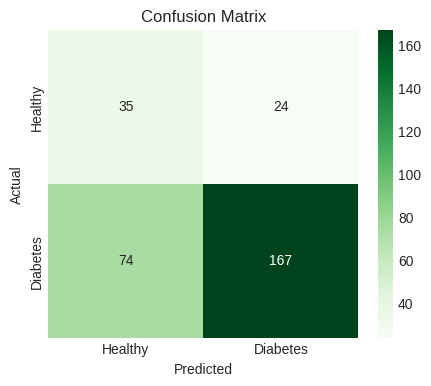

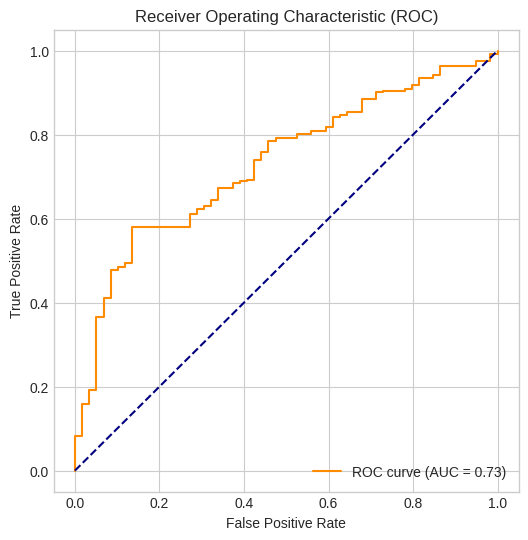

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Using the intial model parameters
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.6).astype(int)

print("--- Final Performance Metrics ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Healthy', 'Diabetes'],
            yticklabels=['Healthy', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()